In [31]:
import os
import numpy as np
import cv2
import math
from keras.models import Sequential
from keras.layers import Dense
from copy import copy, deepcopy

seed_value = 99999
os.environ['PYTHONHASHSEED']=str(seed_value)
from numpy.random import seed
seed(seed_value)
import tensorflow as tf
tf.compat.v1.random.set_random_seed(seed_value)
import random
random.seed(seed_value)

from sklearn.datasets import load_boston
from sklearn.linear_model import ElasticNet,ElasticNetCV,Ridge,Lasso,LinearRegression,MultiTaskLasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
calib_dir = 'C:/kitti/training/calib/'
label_2_dir = 'C:/kitti/training/label_2/'
label_2_testing_dir = 'C:/kitti/testing/label_2/'
label_3_dir = 'C:/kitti/training/label_3/'

In [3]:
class Calibration(object):
    """ Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.

        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref

        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]

        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)

        velodyne coord:
        front x, left y, up z

        rect/ref camera coord:
        right x, down y, front z

        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf

        TODO(rqi): do matrix multiplication only once for each projection.
    """

    def __init__(self, calib_filepath, from_video=False):
        if from_video:
            calibs = self.read_calib_from_video(calib_filepath)
        else:
            calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P = calibs["P2"]
        self.P3 = calibs["P3"]
        self.P = np.reshape(self.P, [3, 4])
        self.P3 = np.reshape(self.P3, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(self.V2C, [3, 4])
        self.C2V = inverse_rigid_trans(self.V2C)
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs["R0_rect"]
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P[0, 2]
        self.c_v = self.P[1, 2]
        self.f_u = self.P[0, 0]
        self.f_v = self.P[1, 1]
        self.b_x = self.P[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P[1, 3] / (-self.f_v)

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data

    def read_calib_from_video(self, calib_root_dir):
        """ Read calibration for camera 2 from video calib files.
            there are calib_cam_to_cam and calib_velo_to_cam under the calib_root_dir
        """
        data = {}
        cam2cam = self.read_calib_file(
            os.path.join(calib_root_dir, "calib_cam_to_cam.txt")
        )
        velo2cam = self.read_calib_file(
            os.path.join(calib_root_dir, "calib_velo_to_cam.txt")
        )
        Tr_velo_to_cam = np.zeros((3, 4))
        Tr_velo_to_cam[0:3, 0:3] = np.reshape(velo2cam["R"], [3, 3])
        Tr_velo_to_cam[:, 3] = velo2cam["T"]
        data["Tr_velo_to_cam"] = np.reshape(Tr_velo_to_cam, [12])
        data["R0_rect"] = cam2cam["R_rect_00"]
        data["P2"] = cam2cam["P_rect_02"]
        return data

    def cart2hom(self, pts_3d):
        """ Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        """
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
        return pts_3d_hom

    # ===========================
    # ------- 3d to 3d ----------
    # ===========================
    def project_velo_to_ref(self, pts_3d_velo):
        pts_3d_velo = self.cart2hom(pts_3d_velo)  # nx4
        return np.dot(pts_3d_velo, np.transpose(self.V2C))

    def project_ref_to_velo(self, pts_3d_ref):
        pts_3d_ref = self.cart2hom(pts_3d_ref)  # nx4
        return np.dot(pts_3d_ref, np.transpose(self.C2V))

    def project_rect_to_ref(self, pts_3d_rect):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(np.linalg.inv(self.R0), np.transpose(pts_3d_rect)))

    def project_ref_to_rect(self, pts_3d_ref):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(self.R0, np.transpose(pts_3d_ref)))

    def project_rect_to_velo(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx3 points in velodyne coord.
        """
        pts_3d_ref = self.project_rect_to_ref(pts_3d_rect)
        return self.project_ref_to_velo(pts_3d_ref)

    def project_velo_to_rect(self, pts_3d_velo):
        pts_3d_ref = self.project_velo_to_ref(pts_3d_velo)
        return self.project_ref_to_rect(pts_3d_ref)

    # ===========================
    # ------- 3d to 2d ----------
    # ===========================
    def project_rect_to_image(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P))  # nx3
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def project_rect_to_image_3(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P3))  # nx3
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def project_velo_to_image(self, pts_3d_velo):
        """ Input: nx3 points in velodyne coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.project_velo_to_rect(pts_3d_velo)
        return self.project_rect_to_image(pts_3d_rect)

    def project_8p_to_4p(self, pts_2d):
        x0 = np.min(pts_2d[:, 0])
        x1 = np.max(pts_2d[:, 0])
        y0 = np.min(pts_2d[:, 1])
        y1 = np.max(pts_2d[:, 1])
        x0 = max(0, x0)
        # x1 = min(x1, proj.image_width)
        y0 = max(0, y0)
        # y1 = min(y1, proj.image_height)
        return np.array([x0, y0, x1, y1])

    def project_velo_to_4p(self, pts_3d_velo):
        """ Input: nx3 points in velodyne coord.
            Output: 4 points in image2 coord.
        """
        pts_2d_velo = self.project_velo_to_image(pts_3d_velo)
        return self.project_8p_to_4p(pts_2d_velo)

    # ===========================
    # ------- 2d to 3d ----------
    # ===========================
    def project_image_to_rect(self, uv_depth):
        """ Input: nx3 first two channels are uv, 3rd channel
                   is depth in rect camera coord.
            Output: nx3 points in rect camera coord.
        """
        n = uv_depth.shape[0]
        x = ((uv_depth[:, 0] - self.c_u) * uv_depth[:, 2]) / self.f_u + self.b_x
        y = ((uv_depth[:, 1] - self.c_v) * uv_depth[:, 2]) / self.f_v + self.b_y
        pts_3d_rect = np.zeros((n, 3))
        pts_3d_rect[:, 0] = x
        pts_3d_rect[:, 1] = y
        pts_3d_rect[:, 2] = uv_depth[:, 2]
        return pts_3d_rect

    def project_image_to_velo(self, uv_depth):
        pts_3d_rect = self.project_image_to_rect(uv_depth)
        return self.project_rect_to_velo(pts_3d_rect)

    def project_depth_to_velo(self, depth, constraint_box=True):
        depth_pt3d = get_depth_pt3d(depth)
        depth_UVDepth = np.zeros_like(depth_pt3d)
        depth_UVDepth[:, 0] = depth_pt3d[:, 1]
        depth_UVDepth[:, 1] = depth_pt3d[:, 0]
        depth_UVDepth[:, 2] = depth_pt3d[:, 2]
        # print("depth_pt3d:",depth_UVDepth.shape)
        depth_pc_velo = self.project_image_to_velo(depth_UVDepth)
        # print("dep_pc_velo:",depth_pc_velo.shape)
        if constraint_box:
            depth_box_fov_inds = (
                (depth_pc_velo[:, 0] < cbox[0][1])
                & (depth_pc_velo[:, 0] >= cbox[0][0])
                & (depth_pc_velo[:, 1] < cbox[1][1])
                & (depth_pc_velo[:, 1] >= cbox[1][0])
                & (depth_pc_velo[:, 2] < cbox[2][1])
                & (depth_pc_velo[:, 2] >= cbox[2][0])
            )
            depth_pc_velo = depth_pc_velo[depth_box_fov_inds]
        return depth_pc_velo
        
class Object3d(object):
    """ 3d object label """

    def __init__(self, label_file_line):
        data = label_file_line.split(" ")
        data[1:] = [float(x) for x in data[1:]]

        # extract label, truncation, occlusion
        self.type = data[0]  # 'Car', 'Pedestrian', ...
        self.truncation = data[1]  # truncated pixel ratio [0..1]
        self.occlusion = int(
            data[2]
        )  # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
        self.alpha = data[3]  # object observation angle [-pi..pi]

        # extract 2d bounding box in 0-based coordinates
        self.xmin = data[4]  # left
        self.ymin = data[5]  # top
        self.xmax = data[6]  # right
        self.ymax = data[7]  # bottom
        self.box2d = np.array([self.xmin, self.ymin, self.xmax, self.ymax])

        # extract 3d bounding box information
        self.h = data[8]  # box height
        self.w = data[9]  # box width
        self.l = data[10]  # box length (in meters)
        self.t = (data[11], data[12], data[13])  # location (x,y,z) in camera coord.
        self.ry = data[14]  # yaw angle (around Y-axis in camera coordinates) [-pi..pi]

    def estimate_diffculty(self):
        """ Function that estimate difficulty to detect the object as defined in kitti website"""
        # height of the bounding box
        bb_height = np.abs(self.xmax - self.xmin)

        if bb_height >= 40 and self.occlusion == 0 and self.truncation <= 0.15:
            return "Easy"
        elif bb_height >= 25 and self.occlusion in [0, 1] and self.truncation <= 0.30:
            return "Moderate"
        elif (
            bb_height >= 25 and self.occlusion in [0, 1, 2] and self.truncation <= 0.50
        ):
            return "Hard"
        else:
            return "Unknown"

    def print_object(self):
        print(
            "Type, truncation, occlusion, alpha: %s, %d, %d, %f"
            % (self.type, self.truncation, self.occlusion, self.alpha)
        )
        print(
            "2d bbox (x0,y0,x1,y1): %f, %f, %f, %f"
            % (self.xmin, self.ymin, self.xmax, self.ymax)
        )
        print("3d bbox h,w,l: %f, %f, %f" % (self.h, self.w, self.l))
        print(
            "3d bbox location, ry: (%f, %f, %f), %f"
            % (self.t[0], self.t[1], self.t[2], self.ry)
        )
        print("Difficulty of estimation: {}".format(self.estimate_diffculty()))

def compute_box_3d(obj, P):
    """ Takes an object and a projection matrix (P) and projects the 3d
        bounding box into the image plane.
        Returns:
            corners_2d: (8,2) array in left image coord.
            corners_3d: (8,3) array in in rect camera coord.
    """
    # compute rotational matrix around yaw axis
    R = roty(obj.ry)

    # 3d bounding box dimensions
    l = obj.l
    w = obj.w
    h = obj.h

    # 3d bounding box corners
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

    # rotate and translate 3d bounding box
    corners_3d = np.dot(R, np.vstack([x_corners, y_corners, z_corners]))
    # print corners_3d.shape
    corners_3d[0, :] = corners_3d[0, :] + obj.t[0]
    corners_3d[1, :] = corners_3d[1, :] + obj.t[1]
    corners_3d[2, :] = corners_3d[2, :] + obj.t[2]

    # project the 3d bounding box into the image plane
    corners_2d = project_to_image(np.transpose(corners_3d), P)
    # print 'corners_2d: ', corners_2d
    return corners_2d, np.transpose(corners_3d)

def rotx(t):
    """ 3D Rotation about the x-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])


def roty(t):
    """ Rotation about the y-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])


def rotz(t):
    """ Rotation about the z-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

def project_to_image(pts_3d, P):
    """ Project 3d points to image plane.

    Usage: pts_2d = projectToImage(pts_3d, P)
      input: pts_3d: nx3 matrix
             P:      3x4 projection matrix
      output: pts_2d: nx2 matrix

      P(3x4) dot pts_3d_extended(4xn) = projected_pts_2d(3xn)
      => normalize projected_pts_2d(2xn)

      <=> pts_3d_extended(nx4) dot P'(4x3) = projected_pts_2d(nx3)
          => normalize projected_pts_2d(nx2)
    """
    n = pts_3d.shape[0]
    pts_3d_extend = np.hstack((pts_3d, np.ones((n, 1))))
    # print(('pts_3d_extend shape: ', pts_3d_extend.shape)) 
    pts_2d = np.dot(pts_3d_extend, np.transpose(P))  # nx3
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]
    return pts_2d[:, 0:2]

def read_label(label_filename):
    lines = [line.rstrip() for line in open(label_filename)]
    objects = [Object3d(line) for line in lines]
    return objects

def inverse_rigid_trans(Tr):
    """ Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    """
    inv_Tr = np.zeros_like(Tr)  # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr

def get_distance_for_object(object3d):
    return math.sqrt(object3d.t[0]**2 + object3d.t[1]**2 + object3d.t[2]**2)

In [61]:
files = os.listdir(label_2_dir)
dataset = []
                   
for file in files:
    if not file.endswith(".txt"):
        continue
    
    file_without_extension = os.path.splitext(file)[0]
    left_objects = read_label(os.path.join(label_2_dir, file))     
    calib = Calibration(os.path.join(calib_dir, file))
    
    right_objects = []
    for left_object in left_objects:
        if left_object.type == "DontCare":
            continue
        
        dataset_row = np.zeros(9)
        
        box3d_left = compute_box_3d(left_object, calib.P)   
        left_object.xmin = min(box3d_left[0], key=lambda t: t[0])[0]
        left_object.xmax = max(box3d_left[0], key=lambda t: t[0])[0]
        left_object.ymin = min(box3d_left[0], key=lambda t: t[1])[1]
        left_object.ymax = max(box3d_left[0], key=lambda t: t[1])[1]
        dataset_row[0] = (left_object.xmin + left_object.xmax) / 2
        dataset_row[1] = (left_object.ymin + left_object.ymax) / 2
        dataset_row[2] = left_object.xmax - left_object.xmin
        dataset_row[3] = left_object.ymax - left_object.ymin
        
        box3d_right = compute_box_3d(left_object, calib.P3)      
        right_object = copy(left_object)
        right_object.xmin = min(box3d_right[0], key=lambda t: t[0])[0]
        right_object.xmax = max(box3d_right[0], key=lambda t: t[0])[0]
        right_object.ymin = min(box3d_right[0], key=lambda t: t[1])[1]
        right_object.ymax = max(box3d_right[0], key=lambda t: t[1])[1]
        dataset_row[4] = dataset_row[0] - ((right_object.xmin + right_object.xmax) / 2)
        dataset_row[5] = dataset_row[1] - ((right_object.ymin + right_object.ymax) / 2)
        dataset_row[6] = dataset_row[2] - (right_object.xmax - right_object.xmin)
        dataset_row[7] = dataset_row[3] - (right_object.ymax - right_object.ymin)
        
        dataset_row[8] = get_distance_for_object(left_object)
        
        dataset.append(np.asarray(dataset_row))
    
dataset = np.array(dataset)

In [62]:
from sklearn.model_selection import train_test_split
dataset_x_train,dataset_x_test,dataset_y_train,dataset_y_test = train_test_split(dataset[:, :8],dataset[:, 8],test_size = 0.25)


In [45]:

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

keras.backend.clear_session()
if 'model' in locals():
  del model

# Neural network
model = Sequential()
model.add(Dense(8, input_dim=8, activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="linear"))
opt = Adam(lr=1e-3)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
model.fit(dataset_x_train, dataset_y_train, validation_data=(dataset_x_test, dataset_y_test), epochs=100, batch_size=32)

Train on 30427 samples, validate on 10143 samples
Epoch 1/100
30427/30427 [==============================] - 2s 73us/step - loss: 990.6760 - val_loss: 245.7474
Epoch 2/100
30427/30427 [==============================] - 2s 69us/step - loss: 246.9541 - val_loss: 117.7822
Epoch 3/100
30427/30427 [==============================] - 2s 69us/step - loss: 105.3888 - val_loss: 46.2691
Epoch 4/100
30427/30427 [==============================] - 2s 69us/step - loss: 42.0488 - val_loss: 26.2433
Epoch 5/100
30427/30427 [==============================] - 2s 69us/step - loss: 26.9930 - val_loss: 22.0803
Epoch 6/100
30427/30427 [==============================] - 2s 69us/step - loss: 23.5886 - val_loss: 20.9596
Epoch 7/100
30427/30427 [==============================] - 2s 69us/step - loss: 19.7612 - val_loss: 17.9323
Epoch 8/100
30427/30427 [==============================] - 2s 68us/step - loss: 17.0179 - val_loss: 15.4361
Epoch 9/100
30427/30427 [==============================] - 2s 69us/step - loss: 1

30427/30427 [==============================] - 2s 71us/step - loss: 4.0119 - val_loss: 4.4660
Epoch 77/100
30427/30427 [==============================] - 2s 71us/step - loss: 3.8944 - val_loss: 3.6362
Epoch 78/100
30427/30427 [==============================] - 2s 71us/step - loss: 3.8639 - val_loss: 3.6658
Epoch 79/100
30427/30427 [==============================] - 2s 70us/step - loss: 3.8716 - val_loss: 3.6238
Epoch 80/100
30427/30427 [==============================] - 2s 70us/step - loss: 3.8360 - val_loss: 4.3283
Epoch 81/100
30427/30427 [==============================] - 2s 70us/step - loss: 3.8269 - val_loss: 3.5839
Epoch 82/100
30427/30427 [==============================] - 2s 71us/step - loss: 3.8013 - val_loss: 3.9312
Epoch 83/100
30427/30427 [==============================] - 2s 70us/step - loss: 3.7237 - val_loss: 3.6814
Epoch 84/100
30427/30427 [==============================] - 2s 70us/step - loss: 3.8372 - val_loss: 3.5579
Epoch 85/100
30427/30427 [========================

In [77]:
preds = model.predict(dataset_x_test)
diff = preds.flatten() - dataset_y_test
percentDiff = (diff / dataset_y_test) * 100 
absPercentDiff = np.abs(percentDiff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
print("[INFO] mean squared error: ", mean_squared_error(dataset_y_test, preds.flatten()))

[INFO] mean: 3.80%, std: 5.33%
[INFO] mean squared error:  3.763365857812166


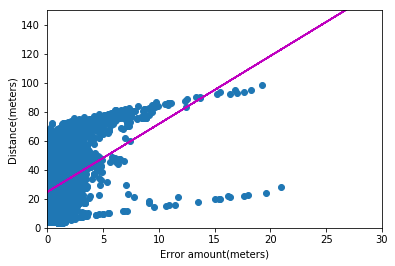

In [78]:
import matplotlib.pyplot as plt

errors = np.abs(diff)
distances = dataset_y_test
plt.scatter(errors, distances)
pfit = np.polyfit(errors, distances, 1)
trend_line_model = np.poly1d(pfit)

plt.plot(errors, trend_line_model(errors), "m--")
plt.axis([0,30,0,150])
plt.ylabel('Distance(meters)')
plt.xlabel('Error amount(meters)')
print("\n")

In [39]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [76]:
model = Sequential()
model.add(Dense(8, input_dim=8, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(4, activation="relu"))
model.add(Dense(1, activation="linear"))
model.load_weights("model-good.h5")
opt = Adam(lr=1e-3)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)